In [1]:
import numpy as np
import matplotlib.pyplot as plt

The temperature in the room $x_t$ is controlled by a heater. It changes the temperature according to the following rule: $0.1*cos(\alpha t)*u_t^2$. Unfortunately, it is malfunctioning and the controls $u_{t,real} = {u}_t + \eta_t$ it exerts are slightly off where $\eta_t \sim \mathcal{N}(0, M)$. Likewise, the temperature deviates from time to time due to the presence of air flows that is modelled by the noise $\epsilon_t \sim \mathcal{N}(0, N)$. The estimated temperature at the moment of time $t$ can be written as follows:

$$x_t = g(x_{t-1}, u_t) = x_{t-1} + \Delta t * 0.1 * cos(\alpha t) * u_t^2 + \epsilon_t$$

Let $\alpha=0.1$, $x_0 = 18$, $\Sigma_0=0$, $\Delta t=0.3$, $M=3$ and $N=0.2$.

In [2]:
alpha = 0.1

x_0 = 18
sigma_0 = 0

dt = 0.3

n = 400

M = 3
R = 0.2
Q = 0.1

In [3]:
np.random.seed(904)

t = np.arange(n)

# Commands that were intended to be executed: u_bar
u = np.random.randint(1, 4, (len(t) - 1)).astype(np.float32)
# Actual executed commands: u_bar + eta
u_real = u + np.random.randn(len(t) - 1) * np.sqrt(M)

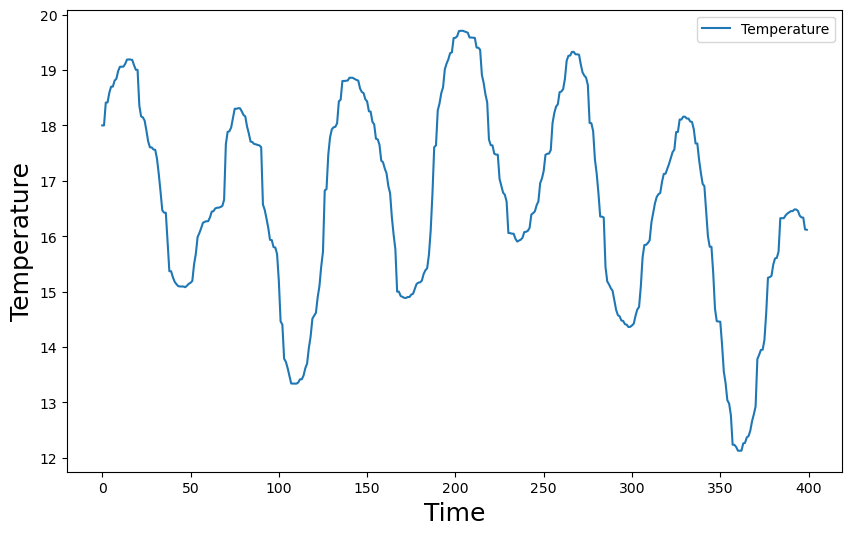

In [4]:
# Actual temperature
x = [x_0]

for t_t, u_t in zip(t[1:], u_real):
    x_t = x[-1] + dt * 0.1 * np.cos(alpha * t_t) * u_t**2
    x.append(x_t)

x = np.array(x)

plt.figure(figsize=(10, 6))
plt.plot(t, x, label='Temperature')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.legend()
plt.show()


## Task 1
Calculate $G_t=\frac{dg(x_{t-1}, u_t)}{dx_{t-1}}\Big|_{\mu_{t-1}}$ and $V_t=\frac{dg(x_{t-1}, u_t)}{du_{t}}\Big|_{{u}_t,\,\eta = 0}$ and perform mean and covariance propagation. Plot the guess on mean values and covariance estimates as 1-sigma interval for each step.

In [5]:
mean_x = [x_0]
cov_x = [sigma_0]

In [6]:
# TODO. Your code here
for t_t, u_t in zip(t[1:], u):
    G_t = 1  # Since x_t = x_{t-1} + dt * 0.1 * cos(alpha*t) * u^2, derivative wrt x_{t-1} is 1
    
    # Calculate V_t = dg/du at u_t (with eta=0)
    V_t = dt * 0.1 * np.cos(alpha * t_t) * 2 * u_t
    
    # Mean propagation
    mean_x_t = mean_x[-1] + dt * 0.1 * np.cos(alpha * t_t) * u_t**2
    mean_x.append(mean_x_t)
    
    # Covariance propagation
    # P_t = G_t * P_{t-1} * G_t^T + V_t * M * V_t^T
    cov_x_t = cov_x[-1] + V_t * M * V_t
    cov_x.append(cov_x_t)


# mean_x = 
sigma1_x = np.sqrt(cov_x)

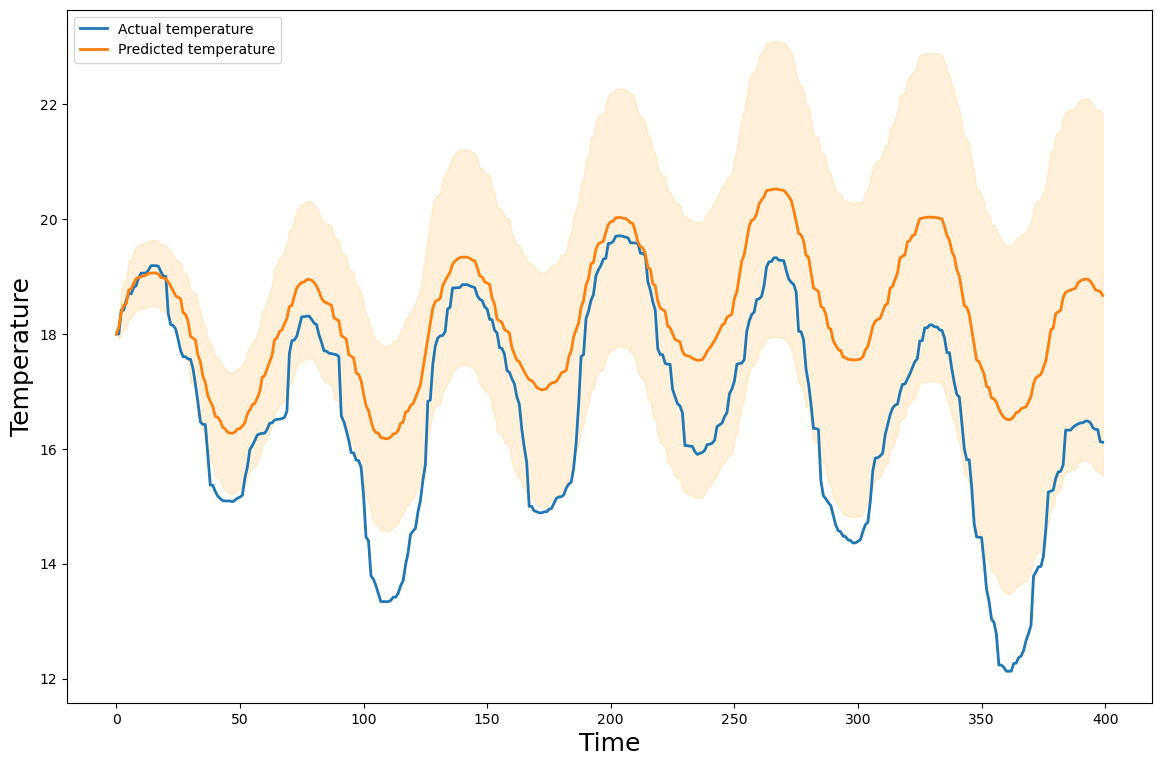

In [7]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Temperature', fontsize=18)

ax.plot(t, x, linewidth=2, label='Actual temperature')
ax.plot(t, mean_x, linewidth=2, label='Predicted temperature')
ax.fill_between(t, (mean_x - sigma1_x), (mean_x + sigma1_x), color='orange', alpha=.15)

plt.legend()

Now, lets assume that we can measure the temperature in the room by using a sensor. The sensor procudes the following observation $z_t = h(x_t) = 2\sqrt{x_t} + \nu_t$ where $\nu \sim \mathcal{N}(0, R)$ and $R = 0.1$.

In [8]:
np.random.seed(1)

R = 0.1

z_noise = np.random.randn(len(t) - 1) * np.sqrt(R)
z = 2 * np.sqrt(x[1:]) + z_noise

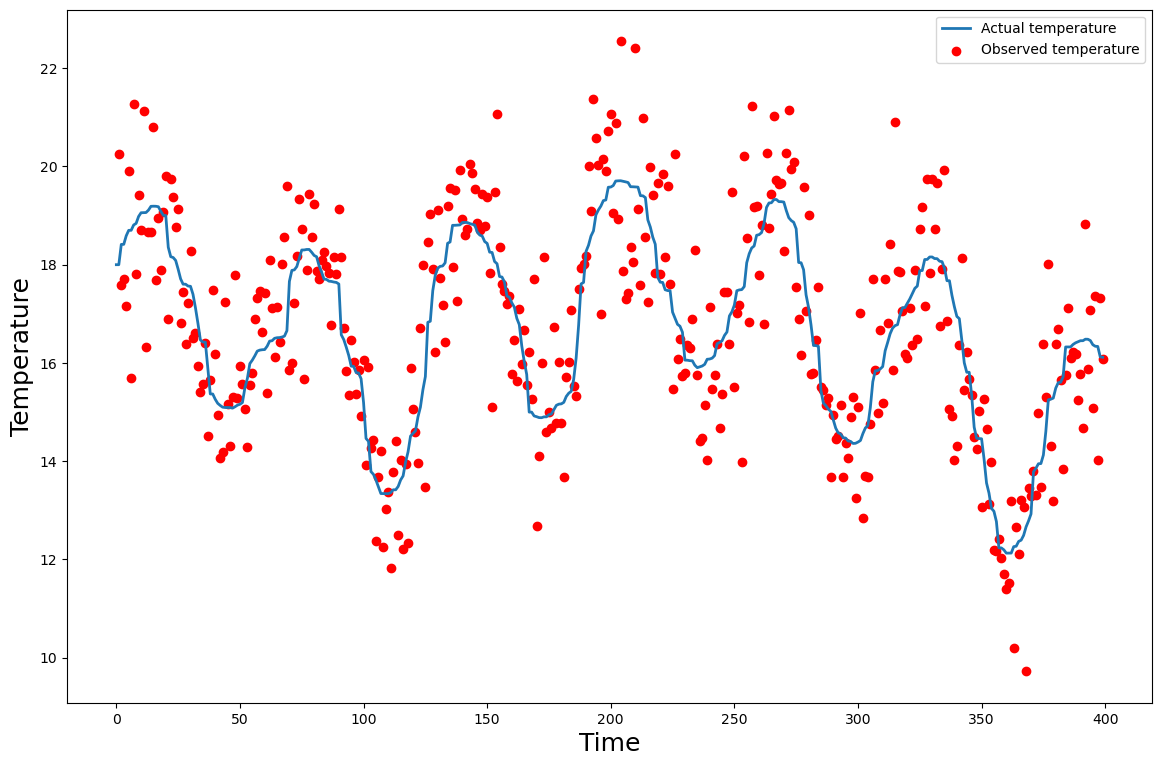

In [9]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Temperature', fontsize=18)

ax.plot(t, x, linewidth=2, label='Actual temperature')
ax.scatter(t[1:], z ** 2 / 4, color='red', label='Observed temperature')

plt.legend()


## Task 2

Calculate $H_t=\frac{dh(x_t)}{dx_t}\Big|_{\mu_t}$ and using the implementation of prediction step from the previous taks finish the implementation of EKF by implementing the update step. Plot mean and covariance 1-sigma and 3-sigma intervals outputed by the algorithm on each step.

In [10]:
mean_x = [x_0]
cov_x = [sigma_0]

In [11]:
mean_x = [x_0]
cov_x = [sigma_0]

for t_t, u_t, z_t in zip(t[1:], u, z):
    # Calculate V_t = dg/du at u_t (with eta=0)
    V_t = dt * 0.1 * np.cos(alpha * t_t) * 2 * u_t
    
    pred_mean = mean_x[-1] + dt * 0.1 * np.cos(alpha * t_t) * u_t**2
    pred_cov = cov_x[-1] + V_t * M * V_t + R
    
    h_t = 1/np.sqrt(pred_mean)
    k_t = pred_cov * h_t * (h_t**2*pred_cov + Q)**-1
    mean_x.append(pred_mean + k_t * (z_t - 2*np.sqrt(pred_mean)))
    cov_x.append((1 - k_t * h_t) * pred_cov)
    
sigma1_x = np.sqrt(cov_x)

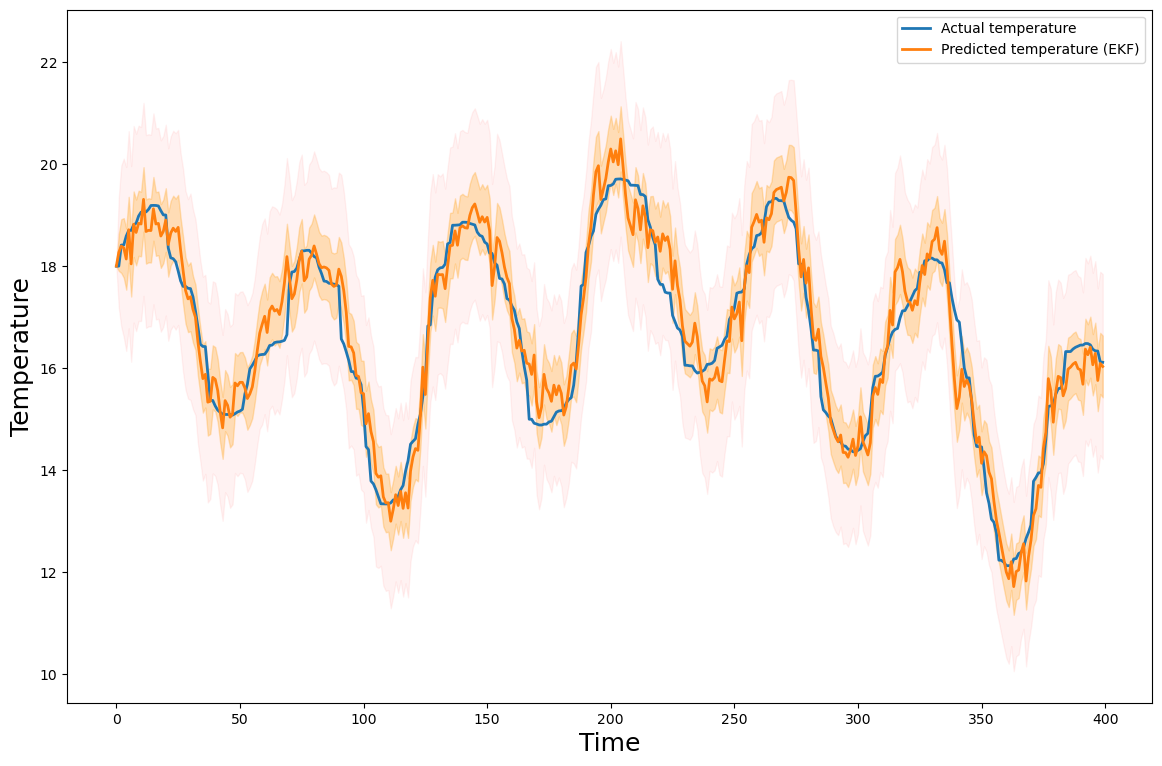

In [12]:
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Temperature', fontsize=18)

ax.plot(t, x, linewidth=2, label='Actual temperature')
ax.plot(t, mean_x, linewidth=2, label='Predicted temperature (EKF)')
ax.fill_between(t, (mean_x - sigma1_x), (mean_x + sigma1_x), color='orange', alpha=.25)
ax.fill_between(t, (mean_x - 3 * sigma1_x), (mean_x + 3 * sigma1_x), color='red', alpha=.05)

plt.legend()